## Motivation

Once single-cell genomics data has been processed, one can dissect important relationships between observed features in their genome context. In our genome, the activation of genes is controlled in the nucleus by the RNA transcriptional machinery, which activates local (promoters) or distal cis-regulatory elements (enhancers), to control the amount of RNA produced by every gene.

Conceptually, a Gene Regulatory Network (GRN) refers to a best-educated graph representation of how certain genes that control transcription i.e. "**Transcription Factors**" (TF) are in charge of directly controlling the transcription rates of their target genes (cis-regulation). At the same time, such target genes once activated, can be in charge of controlling other downstream target genes (trans-regulation). Computationally, methods that infer GRNs consider the co-variation of RNA and ATAC features to identify modules that could be grouped and associated simultaneously with a few TFs. A group of genes controlled by the activity of the same TF is defined as a **regulon**.

In addition to co-variation, several methods have recognized the gathering and injection of prior knowledge data, such as the locations where a TF bind in the genome, or previously reported TF-target gene associations, to pre-define gene-gene edges that guide the inference of GRNs that are most-supported by that type of evidence. To date, benchmarking of GRNs differs from other Machine Learning tasks such as image inference, in such a way that labeled data is sparse and hard to validate. For this reason, several methods have developed their own benchmark that compares new methods against others, using majorly real data. The generalization of GRN inference methods is an active discussion topic in regulatory genomics, and differently from previous chapters, requires a gold standard that is at the moment difficult to agree on and be reused consistently by the community.

The purpose of this chapter is to showcase the general pipeline of how a GRN can be generated, using methods that have been to our knowledge presented in a way that allows a validation with a low amount of software dependencies. Due to the benchmarking limitations of GRN tools in general, we recommend these tools but we cannot say that they will perform best in all possible scenarios. We would rather recommend those as a starting point, given available data, to then explore their generated GRN representations with the lowest computational effort.

#### Gathering TF regulons from public data

TF- Regulons have been annotated in academic studies, databases that compiled those, and also consortia efforts such as ENCODE. As general recommendations, one can inspect [TTRUST](https://www.grnpedia.org/trrust/) {cite}`at:Han2015-yb`, [DoRothEA](https://saezlab.github.io/dorothea/) {cite}`at:Garcia-Alonso2019-ly`, [KnockTF](http://www.licpathway.net/KnockTFv2/index.php) {cite}`at:Feng2020-nl`, among others, for eukaryotic TF-regulons. For prokaryotes [RegulonDB](https://regulondb.ccg.unam.mx/) {cite}`at:Santos-Zavaleta2018-be` is a known and recognized database.

#### **Limitations of TF regulons**

The source and confidence of a TF-regulon have some limitations, such as data source and experimental readout. If the data source for a regulon is not matched to the cell type of interest, then results can not be put into the context of the particular biological system. Alternatively, if the experimental readout is not measuring *cis* regulation events, directly provoked by the TF of interest, our TF-regulon might contain *trans* regulation events. The usage of a TF regulon gathered in an equivalent biological system is strongly recommended. However, if those are not available the interpretation of results might be biased due to the forcing of priors.

## **This chapter: Generation of GRNs using RNA data**

We will explore scRNA-seq data and predicted TF-regulons, using the tool SCENIC. Specifically, we will execute SCENIC {cite}`Aibar2017-tp` on a donor of the NeurIPS 2021 dataset, and we will interpret the results. The main processing steps described in this notebook are adapted based on SCENIC's core tutorials [Tutorial](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

### **Outcome of the analysis**

This notebook allows interpreting single-cell RNA-seq data through the inference of a gene regulatory network, to get potential associations between Transcription Factors and target genes that explain gene expression, in contexts such as cell differentiation, transitions, and perturbations.


## Dataset description
 Cell-type clusters of 100,000 human PBMCs and the NeurIPS dataset, which contain healthy donors as well as COVID-19 patients{cite}`Schulte-chrepping2020`.

### Installation of SCENIC

The package SCENIC requires a variety of tool that are used for the annotation of TF-regulons and the calculation of strong edges between TFs and target genes (see regulons_only_rna.yml for installation requirements)

## Environment setup

In [7]:
import warnings

# here verify all the relevant import that will be required.
warnings.filterwarnings("ignore")
import pyscenic
import loompy as lp
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

## Preparation of the NeurIPs dataset
The current dataset we will be looking here is already pre-processed (previous chapters), and it contains 69,249 cells, annotated into 22 cell types. Due to batch integration considerations, we will demonstrate the usage of GRN methods for only one, labeled as s1d1 (n=6,224 cells).

Load the full dataset

In [8]:
adata = sc.read_h5ad("../../data/openproblems_bmmc_multiome_genes_filtered.h5ad")
adata.shape

(69249, 129921)

Subset RNA only features using the label GEX

In [9]:
rna = adata[:, adata.var.feature_types == "GEX"]
del adata
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [10]:
rna.shape

(69249, 13431)

Here we select highly-variable genes, to minimize the computing requirements for steps down-stream. An execution without defining HVGs is also possible, but will need additional computing memory and time.

In [11]:
sc.pp.highly_variable_genes(rna, batch_key="batch", flavor="seurat")

In [12]:
sc.set_figure_params(facecolor="white")

This is the embedding of all gene expression data cells of all donors. One can see that donor is dominate over cell types in terms of groups, and batch-correction methods have not been executed.

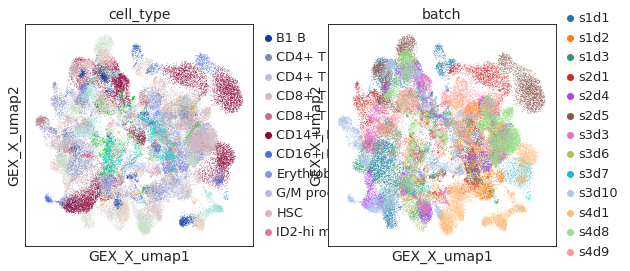

In [13]:
sc.pl.embedding(rna, "GEX_X_umap", color=["cell_type", "batch"])

Here we observe the cells of only donor s1d1. When observing cells for only one donor, cells clusters can identified based on their provided annotations.

custom donor (s1d1)


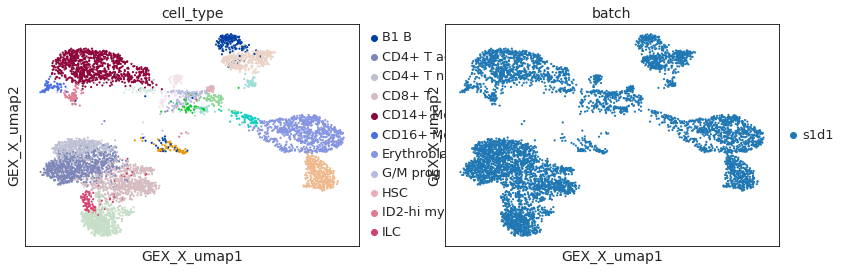

In [14]:
adata_batch = rna[rna.obs.batch == "s1d1", :]
print("custom donor (s1d1)")
sc.pl.embedding(adata_batch, "GEX_X_umap", color=["cell_type", "batch"])

## Preparation of SCENIC

Define the input for SCENIC using loompy

In [15]:
## this file has to be downloaded if not found
!wget -nc https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt

File ‘allTFs_hg38.txt’ already there; not retrieving.



In [16]:
tfs_path = "allTFs_hg38.txt"

In [17]:
loom_path = "data/neurips_processed_input.loom"
loom_path_output = "data/neurips_processed_output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

# check that the needed output file (before execution it should be False/False
print(os.path.exists(loom_path), os.path.exists(loom_path_output))

True True


As a verification, it is recommended to check that genes annotated as TFs are part of the provided input data. If not a high coverage of gene symbols is observed e.g. 50% or more, there could be an issues with the feature names declared in the `.var`, such as Ensembl IDs instead of gene_symbols, or lower/uppercase difference if the genome assembly is mouse or another species that uses a different capitalization style than human.

In [18]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    np.sum(adata_batch.var.index.isin(tfs)),
    "out of",
    len(tfs),
    "TFs are found in the object",
)

1160 out of 1797 TFs are found in the object


Usage of HVG or all features can be defined here, by changing the flag `use_hvg` to `False`.

In [19]:
use_hvg = True
if use_hvg:
    mask = (adata_batch.var["highly_variable"] == True) | adata_batch.var.index.isin(
        tfs
    )
    adata_batch = adata_batch[:, mask]

Create a loom file for NeurIPS donor. If you get an error in this step, verify thath the labels for Gene/CellID/etc. are properly defined.

In [20]:
row_attributes = {
    "Gene": np.array(adata_batch.var.index),
}
col_attributes = {
    "CellID": np.array(adata_batch.obs.index),
    "nGene": np.array(np.sum(adata_batch.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata_batch.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, adata_batch.X.transpose(), row_attributes, col_attributes)

Once the loom file has been generated, we execute `pyscenic` to generate associations between TFs and genes. TF-gene associations are inferred by GRNBoost, and summarized by a directional weight between TFs and target genes. The output of this analysis is a table summarizing all reported associations with their importance weight.

Some steps below require indicating a number of cores (`num_workers`). Increase according to computing resources available

In [21]:
num_workers = 3

In [22]:
outpath_adj = "adj.csv"
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers}

Show the top of of TF-target associations

In [23]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print("# associations", results_adjacencies.shape)
results_adjacencies.head()

# associations (683484, 3)


,TF,target,importance
0,SOX6,SLC4A1,186.835278
1,SOX6,ANK1,162.917264
2,SOX6,HBA2,143.750583
3,SOX6,SLC25A37,127.603415
4,HMGB2,UBE2S,123.732197


Visualize the distribution of weights for general inspection of the quantiles and thresholds obtained from pyscenic. As provided by the pyscenic grn step, the importance scores follow a unimodel distribution, and negative/posititve values refer to TF-gene associations with less/more importance/respectively.

(-10.0, 10.0)

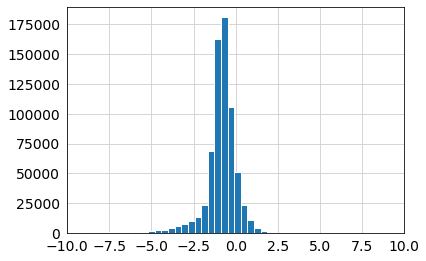

In [24]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

As targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes. Next, we use an annotation of TF associations to Transcription Start Sites (TSSs) to refine this annotation.

Download TSS annotations precalculated by Aerts's lab

In [25]:
!wget -nc https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather

--2023-02-01 00:34:26--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-01 00:34:31 ERROR 404: Not Found.



In [26]:
import glob
import os

# ranking databases
db_glob = "*feather"
db_names = " ".join(glob.glob(db_glob))

Download a catalog of motif-to-TF associations

In [27]:
!wget -nc https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

File ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’ already there; not retrieving.



In [28]:
# motif databases
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
assert os.path.exists(motif_path)

Using the catalog of motif and their gene associations at promoters, retrieved a subset adjacencies by pruning of the previous adjacencies.
This step can take ~8 minutes in a laptop.

In [29]:
if not os.path.exists('reg.csv'):
    !pyscenic ctx adj.csv \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output reg.csv \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic_ctx_stdout.txt

To explore the candidates reported, it is recommended as a rule of thumb to explore the output by the ranking of relative contribution, or by top-quantile thresholds defined visually, to obtain a high signal-to-noise ratio.

Define custom quantiles for further exploration

In [30]:
import numpy as np

n_genes_detected_per_cell = np.sum(adata_batch.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01     101.0
0.05     144.0
0.10     171.0
0.50     259.0
1.00    1387.0
dtype: float64


The histogram below indicates the distribution of genes detected per cell, and is convenient to visualize to define the parameter `--auc_threshold` in the following step. Specifically, the default parameter of `--auc_threshold` in the next step is 0.05, which in this plot would be `144` genes, to be use as reference per cell for AUCell calculations. Modifying this parameter would affect the final estimation of AUCs calculated by AUCell.

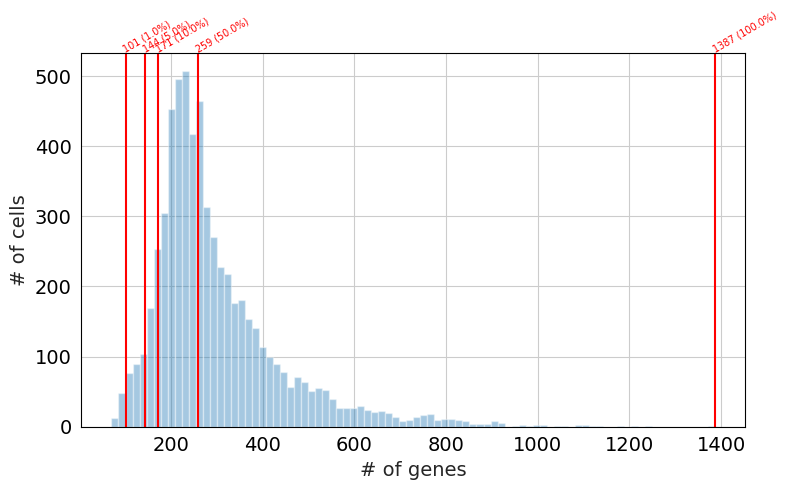

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

This step will use TFs to calculate Area Under the Curve scores, that summarize how well the gene expression observed in each cell can be associated by the regulation of target genes regulatred by the mentioned TFs.

In [32]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

Using the above-generated matrix of cell x TFs and those scores, we can calculate a new embedding using only those.

In [33]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [34]:
if not os.path.exists(loom_path_output):
    !pyscenic aucell $loom_path \
        reg.csv \
        --output {loom_path_output} \
        --num_workers {num_workers} > pyscenic_aucell_stdout.txt

In [51]:
import anndata

ad_auc_mtx = anndata.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

         Falling back to preprocessing with `sc.pp.pca` and default params.


Visualize the data base on the TF-regulons and auc_mtx generated.

In [53]:
adata_batch.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
adata_batch.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

This UMAP visualization confirms that the signal from SCENIC is capable of capturing regulons that keep dividing most cell populations into sub-groups. Hence, there is information TF-regulons that enables cell-type identification.

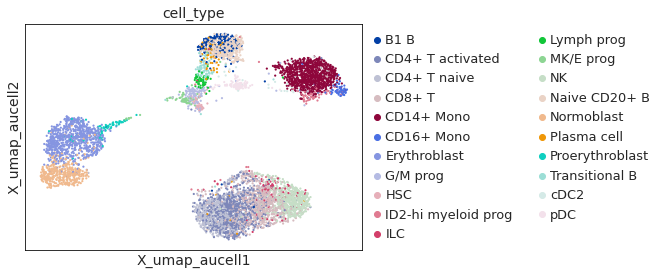

In [55]:
sc.pl.embedding(adata_batch, basis="X_umap_aucell", color="cell_type")

A visualization of the tSNE values generated by SCENIC also confimrs this cell-type separation, for the majority of cell-types

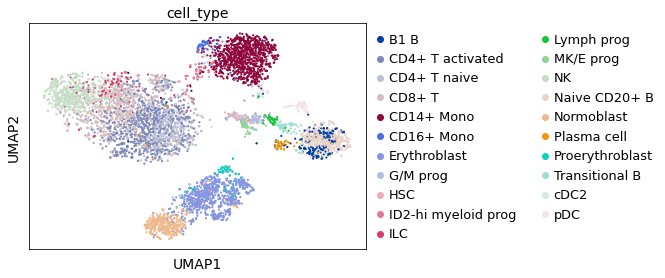

In [37]:
sc.pl.embedding(adata_batch, basis="X_tsne_aucell", color="cell_type")

### **Interpretation of results**

In [38]:
import seaborn as sns

In [39]:
auc_mtx["cell_type"] = adata_batch.obs["cell_type"]
mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()

show the top N TF regulons by a color

In [40]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

Once we know the top TF-regulons involved in the biological system we are studying, we can inspect the activities estimated by each TF, based on the scores per cell, or the overall AUCs per cell-type explained by those TF (blue heatmap below).

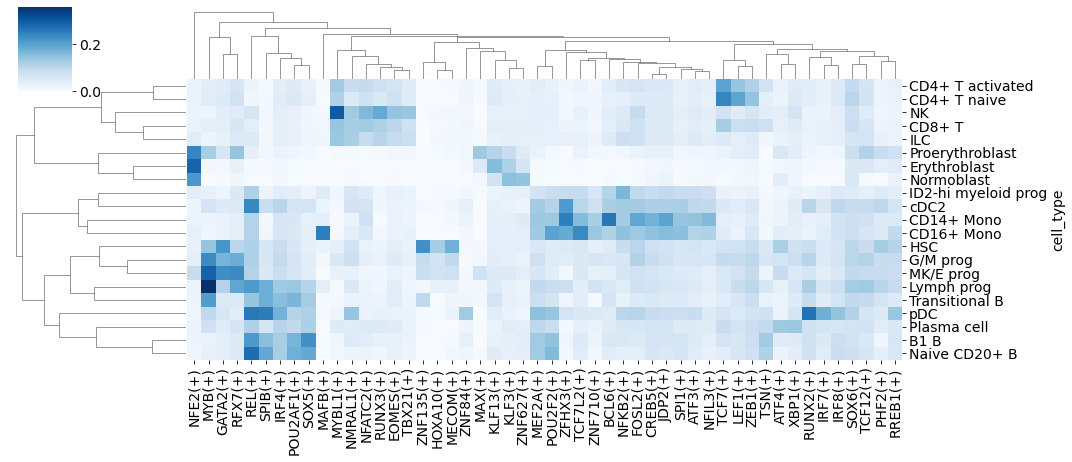

In [41]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

As the red heatmap is suggesting that some TFs are strongly associated to particular cell types, we can verify the expression of their expression levels as an additional validation. This is done by matching the TF names we want to highlight, and visualize those using Scanpy's (red heatmap).

In [42]:
tf_names = top_tfs.index.str.replace("\(\+\)", "")
adata_batch_top_tfs = adata_batch[:, adata_batch.var_names.isin(tf_names)]

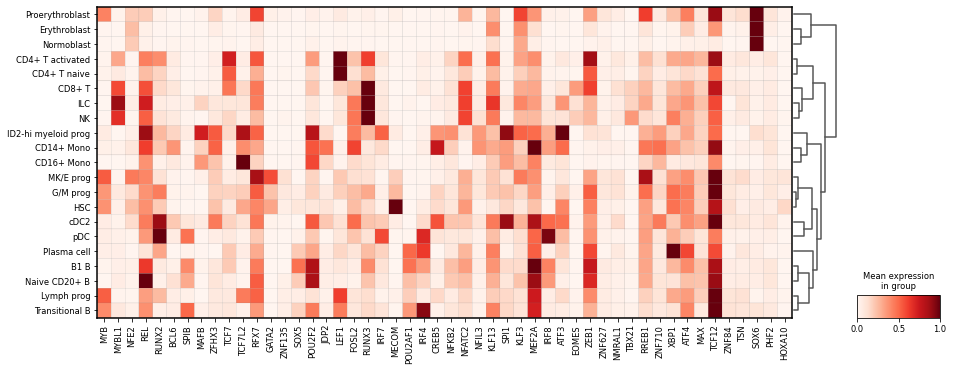

In [43]:
sc.pl.matrixplot(
    adata_batch,
    tf_names,
    groupby="cell_type",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)

Through visual inspection and comparison of the TF-regulon AUC scores and TF gene expression by cell type, we can verify that in several case the cell-type specific expression of a TF is linked to a particular cell type, where the respective TF-regulon is also active e.g. RUNX2 in pDCs, TCF7L2 in CD16+ Mono, LEF1 in CD4+ T activated. Additional inspection can serve to validate previous insights and/or additional associations.

## Preparation of data for RNA+ATAC notebook

Calculations in the next notebook require prior co-variation weights calculated for ATAC/RNA features, that will be done here for convenience.

Preparation of **RNA** for RNA+ATAC notebook (s1d1)

In [3]:
import scanpy as sc
import os
from matplotlib import rcParams
import pandas as pd

path_s1d1 = "../../data/openproblems_bmmc_multiome_genes_filtered_s1d1.h5ad"
# print(os.path.exists(path_s1d1), path_s1d1)
if not os.path.exists(path_s1d1):
    adata = sc.read_h5ad("../../data/openproblems_bmmc_multiome_genes_filtered.h5ad")
    adata_s1d1 = adata[adata.obs.batch == "s1d1", :]
    adata_s1d1.write(path_s1d1, compression="lzf")
    del adata

adata_s1d1 = sc.read_h5ad(path_s1d1)

AnnData object with n_obs × n_vars = 6224 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

Setting for plotting of UMAPs with a white background and low dpi

In [45]:
from matplotlib import rcParams

rcParams["figure.facecolor"] = "white"
rcParams["figure.figsize"] = 5, 5
rcParams["figure.dpi"] = 65

custom batch (input


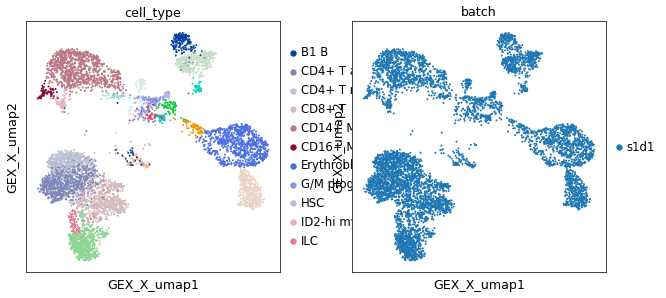

In [46]:
rna = adata_s1d1[:, adata_s1d1.var.feature_types == "GEX"]
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

print("custom batch (input")
sc.pl.embedding(rna, "GEX_X_umap", color=["cell_type", "batch"])

In [47]:
# define hvgs in RNA
sc.pp.highly_variable_genes(rna)

In [48]:
rna.var["transcription_factor"] = rna.var.index.isin(tfs)
rna.var.transcription_factor.value_counts()

False    12271
True      1160
Name: transcription_factor, dtype: int64

In [49]:
rna_hvg_sorted = rna[
    :,
    rna.var.sort_values(
        ["transcription_factor", "dispersions_norm"], ascending=[False, False]
    ).index,
].copy()

In [50]:
# rna_dense = pd.DataFrame(data=rna.X.todense())
# rna.var.to_csv('../../data/openproblems_bmmc_multiome_genes_filtered_rna_s1d1_var.csv.gz', index=True, compression='gzip')
rna_hvg_sorted.to_df().to_csv(
    "../../data/openproblems_bmmc_multiome_genes_filtered_rna_s1d1.csv.gz",
    compression="gzip",
)

Preparation of **ATAC** for RNA+ATAC notebook (donor **s1d1**)

In [51]:
atac = adata_s1d1[:, adata_s1d1.var.feature_types == "ATAC"]

In [52]:
n_features_atac = 20_000
if n_features_atac is not None:
    sc.pp.highly_variable_genes(atac, n_top_genes=n_features_atac)
    atac = atac[:, atac.var.highly_variable]
atac

View of AnnData object with n_obs × n_vars = 6224 × 20947
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'hvg'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

custom batch (input)


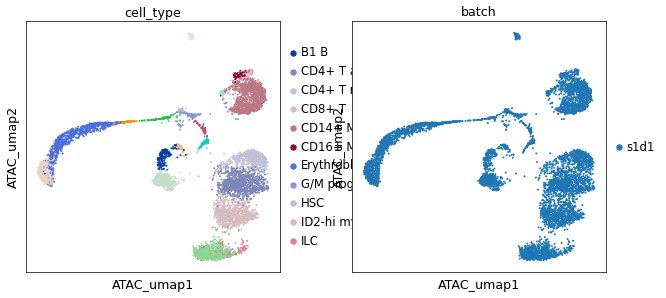

In [53]:
print("custom batch (input)")

from matplotlib import rcParams

rcParams["figure.figsize"] = 5, 5
rcParams["figure.facecolor"] = "white"

sc.pl.embedding(atac, "ATAC_umap", color=["cell_type", "batch"])

In [54]:
atac_obs = atac.obs
atac_obs["UMAP1"] = atac.obsm["ATAC_umap"][:, 0]
atac_obs["UMAP2"] = atac.obsm["ATAC_umap"][:, 1]

In [55]:
atac_obs.to_csv(
    "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_obs.csv.gz"
)

In [56]:
atac_df = atac.to_df().T

atac_df["chr"] = atac_df.index.str.split("-").str[0]
atac_df["start"] = atac_df.index.str.split("-").str[1]
atac_df["end"] = atac_df.index.str.split("-").str[2]

# locate at the beginning of the dataframe
for i, c in enumerate(["chr", "start", "end"]):
    print(i, c)
    column_to_move = atac_df.pop(c)
    atac_df.insert(i, c, column_to_move)
atac_df = atac_df.T
print(atac_df.shape)

0 chr
1 start
2 end
(6227, 20947)


In [57]:
atac_bkp_path = (
    "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_features_times_cells%s.csv.gz"
    % ("" if n_features_atac is None else ("_npeaks" + str(n_features_atac)))
)
if not os.path.exists(atac_bkp_path):
    atac_df.T.to_csv(atac_bkp_path, compression="gzip")
print(atac_df.T.shape, os.path.exists(atac_bkp_path), atac_bkp_path)

(20947, 6227) True ../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_features_times_cells_npeaks20000.csv.gz


## Takeaways

In this notebook, we have:

1. Setup a basic pipeline to prepare, execute, and verify SCENIC results using the NeurIPs 2021 dataset.
2. Detected TF-regulons that allow to explain the observed transcriptomes by the regulatory potential of a handful of TFs.


## Quiz

### Theory
1. How many genes in the human/mouse genome are considered TFs?
2. What is a TF-regulon?
3. How many DNA-binding motifs are there to each TFs?
    3.1. Currently, are there more known DNA-binding motifs or TFs that bind those?
    3.2. How can one reconcile the redundancy of these during the analysis?
4. Additional reading: Describe the futility theorem.

### SCENIC
1. Describe the major steps in the SCENIC pipeline (three or more)?
2. What could happen if the number of TFs reported in your own data has a low overlap to the one externally retrieved?
3. What is the AUC score from pyscenic and how it can be helpful for interpretation of results per cell cluster?

## References

```{bibliography}\n",
:filter: docname in docnames
:labelprefix: anno
```

## Contributors
We gratefully acknowledge the contributions of:
### Authors
* Ignacio Ibarra
### Reviewers
* Lukas Heumos
* Anna Schaar